<a href="https://colab.research.google.com/github/pedrohortencio/kaggle-competitions/blob/main/TMDB/TMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Competition's Page](https://www.kaggle.com/c/tmdb-box-office-prediction/overview)

In [2]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!kaggle competitions download -c tmdb-box-office-prediction

kaggle.json
  0% 0.00/60.1k [00:00<?, ?B/s]
100% 60.1k/60.1k [00:00<00:00, 48.7MB/s]
 71% 5.00M/7.05M [00:01<00:00, 3.48MB/s]
100% 7.05M/7.05M [00:01<00:00, 4.86MB/s]
 48% 5.00M/10.4M [00:01<00:01, 3.61MB/s]
100% 10.4M/10.4M [00:01<00:00, 7.17MB/s]


In [3]:
import numpy as np                  
import pandas as pd
import ast

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white', palette='muted')

from sklearn.model_selection import train_test_split
import xgboost as xg

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
sample = pd.read_csv("/content/sample_submission.csv")
df_train = pd.read_csv("/content/train.csv.zip", compression='zip')
df_test = pd.read_csv("/content/test.csv.zip", compression='zip')

In [76]:
print(df_train.shape)
df_train.head(2)

(3000, 23)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


In [77]:
print(df_test.shape)
df_test.head(2)

(4398, 22)


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,3001,"[{'id': 34055, 'name': 'Pokémon Collection', '...",0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",http://www.pokemon.com/us/movies/movie-pokemon...,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,/tnftmLMemPLduW6MRyZE0ZUD19z.jpg,{},"[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...",7/14/07,90.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de..."
1,3002,{},88000,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,/9MgBNBqlH1sG4yG2u4XkwI5CoJa.jpg,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/19/58,65.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de..."


In [12]:
df_train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [13]:
df_test.isna().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [73]:
columns_with_dicts = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']
def dict_columns(df):
    for column in columns_with_dicts:

        df[column] = df[column].apply(lambda row: {}
                                      if pd.isna(row)   # empty dict if NaN, the value if not
                                      else ast.literal_eval(row))  # (evaluated to see if it is a Python valid data structure)
                                                                                               

    return df

df_train = dict_columns(df_train)
df_test = dict_columns(df_test)

In [74]:
df_train.head(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435


In [75]:
df_train.isna().sum()

id                          0
belongs_to_collection       0
budget                      0
genres                      0
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies        0
production_countries        0
release_date                0
runtime                     2
spoken_languages            0
status                      0
tagline                   597
title                       0
Keywords                    0
cast                        0
crew                        0
revenue                     0
dtype: int64

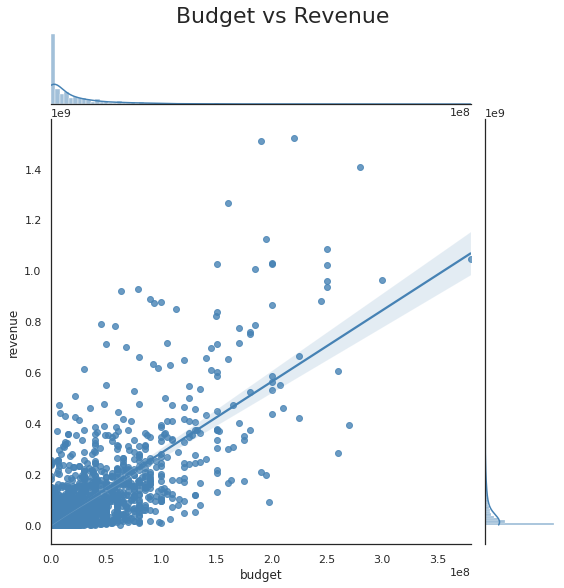

In [60]:
sns.jointplot(x="budget", y="revenue", kind='reg',data=df_train, color='steelblue', height=8)
plt.suptitle("Budget vs Revenue", size=22, y=1.02)
plt.show();

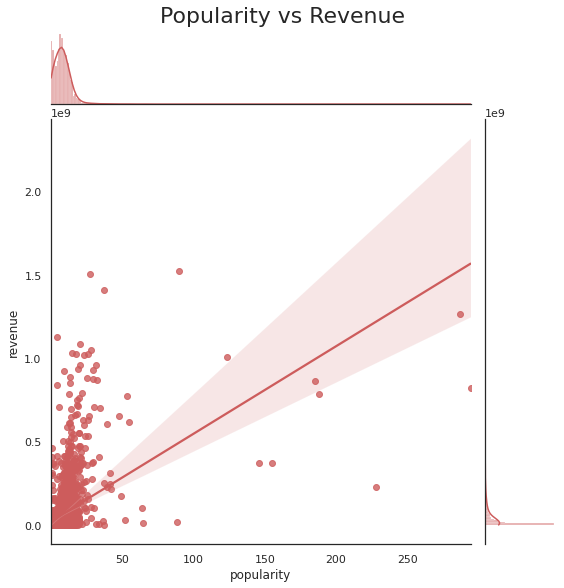

In [62]:
sns.jointplot(x="popularity", y="revenue", kind='reg',data=df_train, color='indianred', height=8)
plt.suptitle("Popularity vs Revenue", size=22, y=1.02)
plt.show();

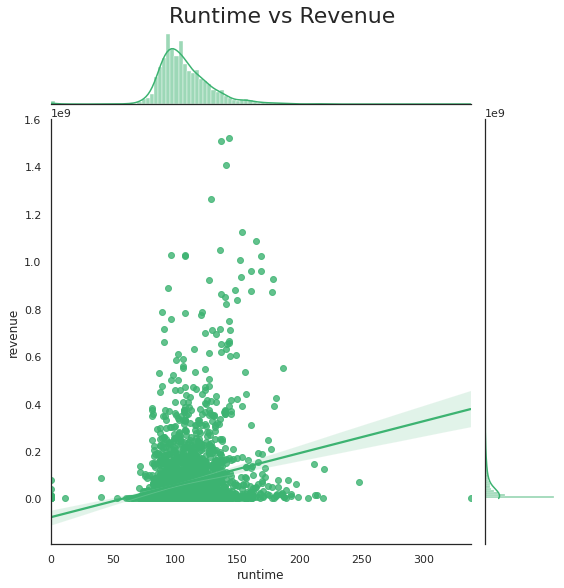

In [64]:
sns.jointplot(x="runtime", y="revenue", kind='reg',data=df_train, color='mediumseagreen', height=8)
plt.suptitle("Runtime vs Revenue", size=22, y=1.02)
plt.show();

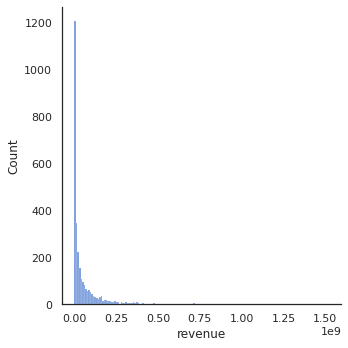

In [69]:
sns.displot(df_train.revenue);